# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called Stochastic Gradient Descent (SGD), to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop ridge regression algorithm (linear regression with $\ell_2$ regularization).



*_Notes_*
*My answers or explanations will go in italics*
*I recommend watching this video on SGD first https://www.youtube.com/watch?v=hMLUgM6kTp8


## Instructions
<ol>
	<li>Generate a synthetic dataset suitable for regression and divide it to train and test sets,
    <li>Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and termination threshold $\epsilon$.</li>
	<li> Use the above function and repeat the following until the difference between the old and new weight vectors becomes small (i.e., $d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n$</li>
</ol>
</li>
</ol>
</li>
	<li>Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$</li>
    <li>Plot the training and testing errors vs. iteration number $\tau$.</li>
    <li>Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value</li>
</ol>

## Implementation
### Dataset
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a weight vector (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

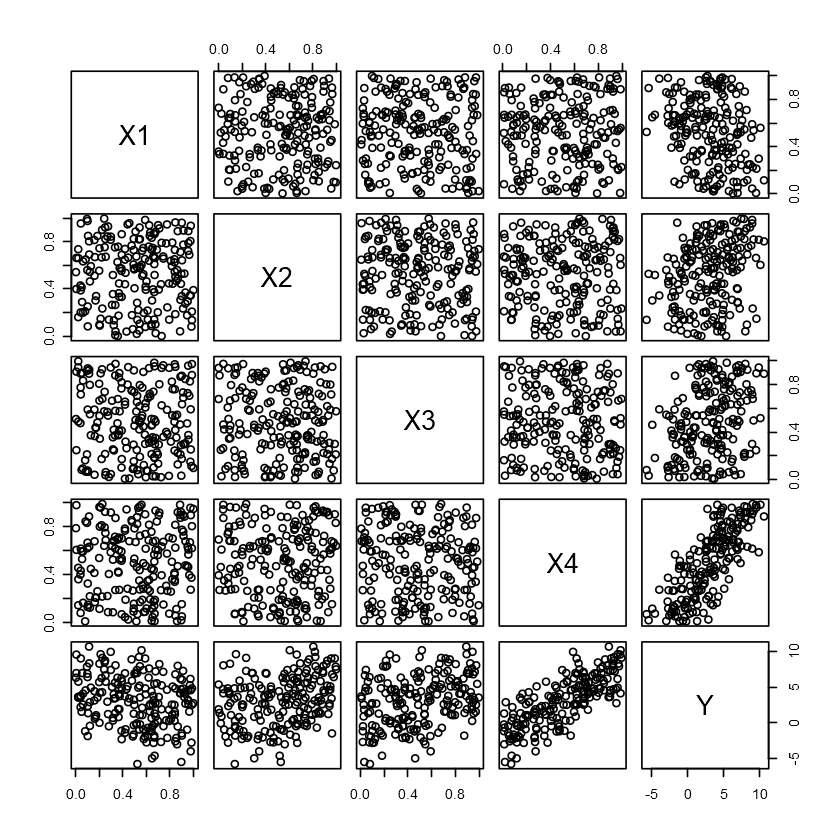

In [20]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
set.seed(1235) # to make the results of stochastic methods reproducible

# geberate N x D data samples
N <- 200 # number of all data point (test and train)
D <- 4 # number of features/attributes
data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D))

# generate the labels
coeff <- matrix(c(-5,-3,4,5,10), D+1, 1) # the real coefficient to be estimated
data <- cbind(data,'Y'=as.matrix(cbind(1,data[,1:D])) %*% coeff)
# add gaussian noise the labels (just to make it a little bit more challenging)
data$Y <- data$Y + rnorm(N, mean = 0, sd =1)
pairs(data)

Now, divide the dataset into testing and training sets

In [21]:
# divide data into training and testing sets
train.len <- N/2
train.index <- sample(1:N,train.len)
train.data <- data[train.index,  1:D]
train.label <- data[train.index, 'Y']
test.data <- data[-train.index, 1:D]
test.label <- data[-train.index, 'Y']

## Implementation
Now, based on the instruction, we initialize the parameter values.

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

*We want a function that can be used to predict the label based of the weights (denoted here as w $\omega$) and basis function values (denoted as phi $\phi$)*

*From 2.2 We saw the likelihood function is maximised if the loss function is minimised. This loss function is essentially the same as 1/2 Sum of Square Error*

In [22]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w) # %*% is matrix multiplication. 
} 

# auxiliary function to calculate a cost function
error_func <- function (Phi, w, label){
    return(sum((predict_func(Phi, w) - label)^2)/2)  # 1/2 of Sum of Square Error
}

#Gradient Error Function used for Batch Gradient Descent
grad_error_func <- function(Phi,w,label){
    err<-as.matrix(predict_func(Phi, w)- label)
    return(t(err)%*%as.matrix(Phi))
}

### Initialization

*This is just the parameters for the SGD. The number of iterations, the learning rate etc the cost threshold.*

In [23]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 50 #The expected error due to 100 elements of sd 1 noise

W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

*The minimum error value is designated as epsilon was changed here to be the unremovable error of 50 based on the expected SSE of the gaussian distribution used

### Main Loop

The algorithm applied here is slightly different to alexandria notes

1. intialise parameters to w(0) and tau = 1
2. While stopping condition is not met
   - Shuffle the order of the default 100 data values
   - For the number of training elements
     _ Update weights based of error between training label and prediction of single datapoint
     _ Increase Tau by 1

In [24]:
while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        tau <- tau + 1        
    }
}
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -3.817403 -3.400682 3.388531 4.3271 9.564094

*Good results are achieved with a learning rate of 0.01 after 10000 iterations. Even with more iterations the final coefficients do not change drastically.

### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

Warning message:
"Removed 2 rows containing missing values (geom_path)."

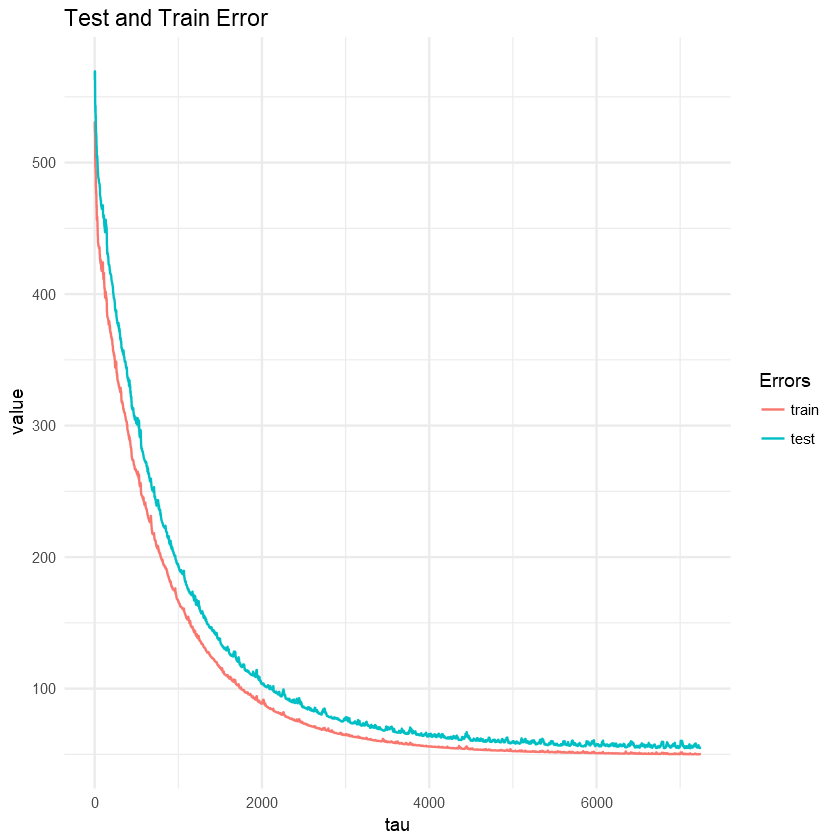

In [25]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()
  

Now let's plot the elements of the learned weight vectors over the training iterations.

Warning message:
"Removed 13790 rows containing missing values (geom_path)."

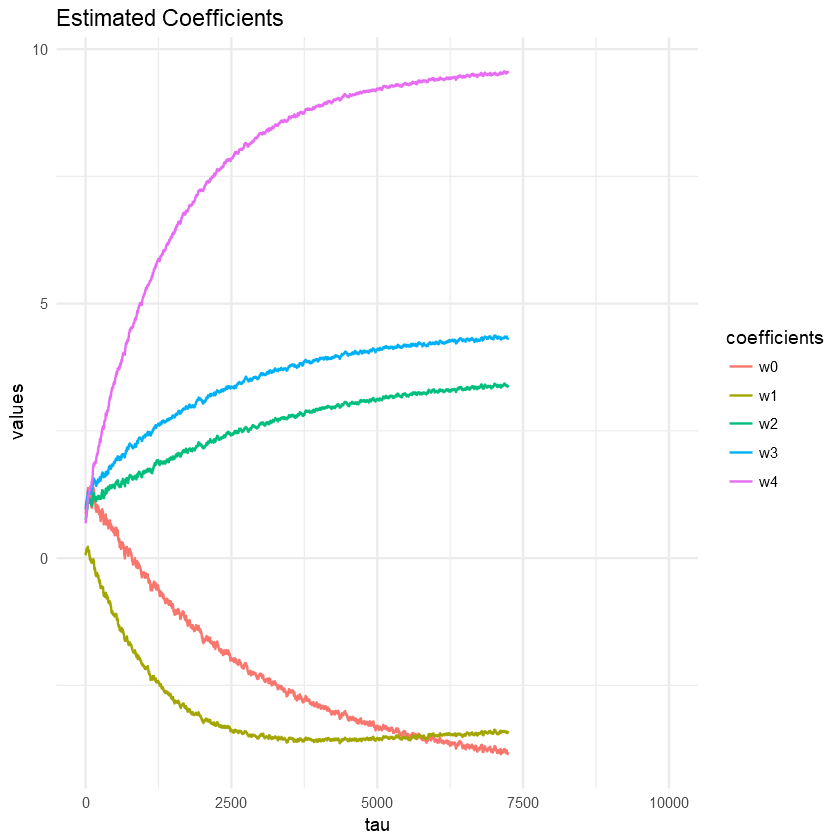

In [26]:
W.m <- as.data.frame(W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()

# Discussions

## Question 1
    1. How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.</li>

*I assumed convergence meant that the model coefficients does not change by more than 1% over a hundred steps. I also quantified the stability of the final result by reporting the the final test error and the standard deviation of the test error on the last 100 iterations. We would expect that if the learning rate is too high, it would not have a stable final test error since it would be moving around the optimal solution rather than converging towards it.

In [27]:
#Code that sets up above algorithm as a function that is callable
sgd <- function(train.data = train.data,test.data = test.data,train.label= train.label,test.label = test.label, tau.max = 10000, eta = 0.01, epsilon = 50){
    
    
    # project data using a basis function (identical here)
    Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0
    T = train.label
    W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients for each Phi at each iteration
    set.seed(1234)
    W[1,] <- runif(ncol(Phi)) # initial weights. N.B. runif generates a random value from a uniform distribution between 0 and 1
                          # Random values are considered good choices but different starting values can result in 
                          # different local minima values. 

    error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

    tau <- 1 # iteration counter
    terminate <- FALSE #Flag to tell the Loop to stop running
    
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon  # Either the iteration number is at the max or 
                                                                       # The error is below the threshold to stop
    
        
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break} #Stop the for loop if 
                                                                                          # stopping conditions reached see above
        
        t_pred = predict_func(Phi[i,], W[tau,]) #Matrix multiply current weights and phi values
        
        # for each coefficient:
        for (j in 1:ncol(W)){
            
            # update the coefficient based on the learning rate and the error. 
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        tau <- tau + 1        
        }
    }
    error.m <- melt(error[1:tau,], id='tau')

    # the  final result is:
    w <- W[tau,]

    return(new("SGDResult",
          W=W,
          tauend=tau,
          error= error.m))
}


setClass(Class="SGDResult",
         representation(
            W="matrix",
            tauend="numeric",
            error = "data.frame"
          )
)

In [28]:
#Now we can test if different learning rates affect the result*
for (eta in c(0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.5)){
    #Run the Algorithm
    result <- sgd(train.data,test.data,train.label,test.label, tau.max = 10000,eta = eta,epsilon = epsilon)
    
    #Define Boolean Conditions for cleaner lookups
    testerror.cond <- result@error[,'variable'] == 'test'  #Test error
    trainerror.cond <- result@error[,'variable'] == 'train' #Train error
    finaltau.cond <- result@error[,'tau'] == result@tauend-1  #Last step condition
    lasthundstepstau.cond <- result@error[,'tau'] %in% (result@tauend-100):(result@tauend-1) #Last hundred steps condition

    finaltesterror<- result@error[finaltau.cond & testerror.cond,'value']  #Find the final test error
    finaltrainerror <- result@error[finaltau.cond & trainerror.cond,'value'] #Find the final train error
    sdtesterror <- sd(result@error[lasthundstepstau.cond & testerror.cond,'value']) #stand dev of error over final 100 iterations
    
    print(paste('For a learning rate of:',eta,' The model was ended at',result@tauend,' iterations. Train Error:',finaltrainerror,' Test Error:',finaltesterror,
                '+-',sdtesterror))
}

[1] "For a learning rate of: 0.005  The model was ended at 10000  iterations. Train Error: 52.0188984204944  Test Error: 59.2286181500631 +- 0.281356026723644"
[1] "For a learning rate of: 0.01  The model was ended at 6962  iterations. Train Error: 50.0880833238191  Test Error: 55.2773550851079 +- 1.12585713205472"
[1] "For a learning rate of: 0.02  The model was ended at 3490  iterations. Train Error: 50.2922580642497  Test Error: 57.2738779687111 +- 1.64921833076545"
[1] "For a learning rate of: 0.03  The model was ended at 2387  iterations. Train Error: 50.0091369585394  Test Error: 55.5947034035099 +- 3.91992541903079"
[1] "For a learning rate of: 0.05  The model was ended at 1378  iterations. Train Error: 50.9538536144983  Test Error: 54.4477032901184 +- 3.37127045022166"
[1] "For a learning rate of: 0.1  The model was ended at 715  iterations. Train Error: 51.8156843498137  Test Error: 60.7657640325837 +- 7.92598387680536"
[1] "For a learning rate of: 0.2  The model was ended at 

*As expected there is a tradeoff in the number of iterations and the final test error.If the learning rate is too low, the model does not converge within the maximum number of iterations whereas if the learning rate is too high, the model is too unstable and a large test error results. A good value will converge quickly and result in a low test error.

** The best value is chosen to be a learning rate of 0.01 here due to the good tradoff in mentioned properties

## Question 2    
    2. Do you believe having different learning rates at different iterations of the main learning loop can help? 
     If it matters, is it better to have large values at start and smaller when close to finish or the other way around?
     Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for  
     different values of $a$ and $b$).



*In theory, having a large learning rate at the start and smaller steps as the model starts to converge should result in a good mix of speed and and low final test error. This can be investigated for different values of a and b so a monotonic decreasing function is the result. 

In [29]:
#Code that sets up above algorithm as a function that is callable
sgd_droppingeta <- function(train.data = train.data,test.data = test.data,train.label= train.label,test.label = test.label, tau.max = 10000, epsilon = epsilon, eta_a = 20,eta_b =2000){
    
    
    # project data using a basis function (identical here)
    Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0
    T = train.label
    W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients for each Phi at each iteration
    set.seed(1234)
    W[1,] <- runif(ncol(Phi)) # initial weights. N.B. runif generates a random value from a uniform distribution between 0 and 1
                          # Random values are considered good choices but different starting values can result in 
                          # different local minima values. 

    error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

    tau <- 1 # iteration counter
    terminate <- FALSE #Flag to tell the Loop to stop running
    eta <- eta_a/(eta_b+tau)
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon  # Either the iteration number is at the max or 
                                                                       # The error is below the threshold to stop
            
        
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
        

    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break} #Stop the for loop if 
                                                                                          # stopping conditions reached see above
        
        t_pred = predict_func(Phi[i,], W[tau,]) #Matrix multiply current weights and phi values
        
        eta <- eta_a/(eta_b+tau)
        
        # for each coefficient:
        for (j in 1: ncol(W)){
            
            # update the coefficient based on the learning rate and the error. 
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        tau <- tau + 1        
        }
    }
    error.m <- melt(error[1:tau,], id='tau')

    # the  final result is:
    w <- W[tau,]

    return(new("SGDResult",
          W=W,
          tauend=tau,
          error= error.m))
}

A grid search is run on different possible values of a and b. The initial learning rate is set to be roughtly within the range found in Q1 to be optimal.

In [30]:
dfChangingEta <- data.frame( "a" = numeric(0),
                            "b" = numeric(0),
                            "initial eta" = numeric(0),
                             "iterations"= integer(0),
                            "train error"= numeric(0),
                           "test error" = numeric(0),
                           "std test error"= numeric(0))

etarow = 0


#This is gonna take a minute or two
for (eta_a in c(0.001,0.01,0.1,1,10,100,1000,10000)){
    for (eta_b in c(0,9,99,9999,99999)){
        
        initeta = eta_a/(eta_b+1)
        
        #Set the maximum and minimum bounds of the initial learning rate and adjust the parameters
        if (initeta <= 1 & initeta>=0.001){
            result <- sgd_droppingeta(train.data,test.data,train.label,test.label, tau.max = 10000,eta_a = eta_a, eta_b = eta_b,epsilon = epsilon)
        
        
            #Define Boolean Conditions for cleaner lookups
            testerror.cond <- result@error[,'variable'] == 'test'  #Test error
            trainerror.cond <- result@error[,'variable'] == 'train' #Train error
            finaltau.cond <- result@error[,'tau'] == result@tauend-1  #Last step condition
            lasthundstepstau.cond <- result@error[,'tau'] %in% (result@tauend-100):(result@tauend-1) #Last thousand steps condition

            finaltesterror<- result@error[finaltau.cond & testerror.cond,'value']  #Find the final test error
            finaltrainerror <- result@error[finaltau.cond & trainerror.cond,'value'] #Find the final train error
            sdtesterror <- sd(result@error[lasthundstepstau.cond & testerror.cond,'value']) #stand dev of error over final 100 iterations
            
            #Assign the results to a dataframe
            etarow = etarow +1
            dfChangingEta[etarow,1] = eta_a
            dfChangingEta[etarow,2] = eta_b
            dfChangingEta[etarow,3] = initeta
            dfChangingEta[etarow,4] = result@tauend
            dfChangingEta[etarow,5] = finaltrainerror
            dfChangingEta[etarow,6] = finaltesterror
            dfChangingEta[etarow,7] = sdtesterror
            }
        }
}

In [31]:
dfChangingEta[order(dfChangingEta$test.error),]

,a,b,initial.eta,iterations,train.error,test.error,std.test.error
17,1e+03,99999,0.010,7216,50.08284,55.13317,1.467156e+00
10,1e+01,9,1.000,8979,50.00232,55.90011,1.811974e-01
14,1e+02,9999,0.010,10000,50.03074,56.13573,2.878892e-01
11,1e+01,99,0.100,10000,52.81670,60.23536,6.150852e-02
16,1e+03,9999,0.100,715,51.63081,60.38003,7.493092e+00
19,1e+04,99999,0.100,715,51.79531,60.72489,7.880089e+00
18,1e+04,9999,1.000,8414,53.18423,63.25200,1.035174e+02
13,1e+02,99,1.000,382,57.68902,71.71103,2.104040e+01
15,1e+02,99999,0.001,10000,170.85574,199.38786,3.598271e-01
7,1e+00,0,1.000,10000,200.93680,235.39560,5.057285e-02


The grid search found that the best test error after 10000 iterations was eta_a = 10, eta_b = 9, so a initial learning rate of 0.1 and a monotonic decreasing learning rate over the iterations. 

In [32]:
#Observe the best result's train and test error over the iterations
eta_a = 10
eta_b = 9

result <- sgd_droppingeta(train.data,test.data,train.label,test.label, tau.max = 10000,eta_a = eta_a, eta_b = eta_b,epsilon = 0)

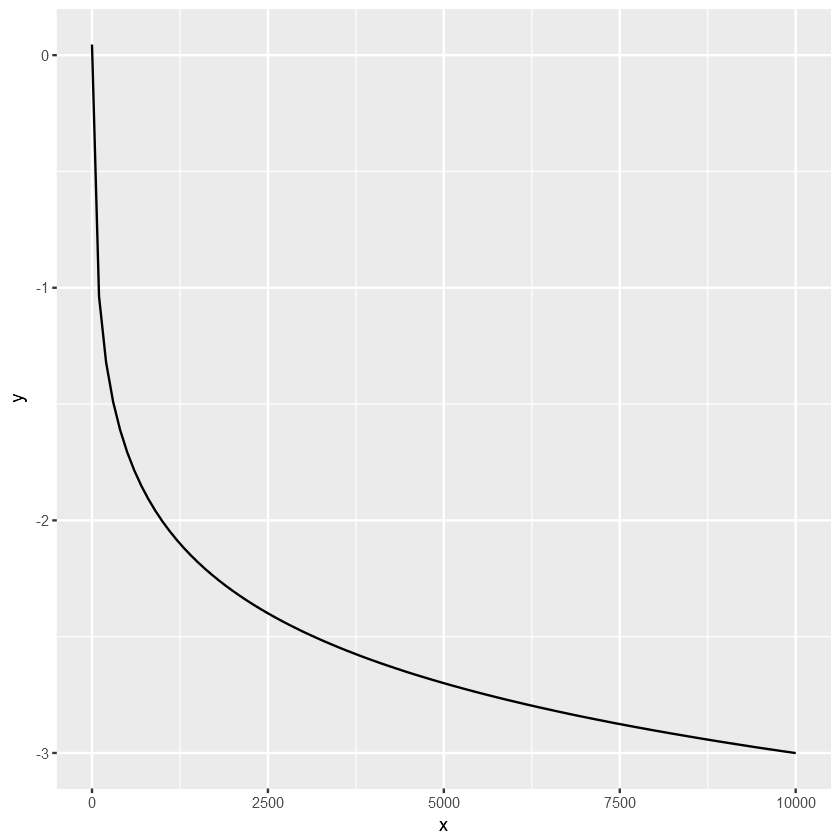

In [33]:
#How does learning rate change over the iterations
ggplot(data.frame(x=c(0, result@tauend)), aes(x)) + stat_function(fun=function(x)(log10(eta_a/(x+eta_b))))

Warning message:
"Removed 2 rows containing missing values (geom_path)."

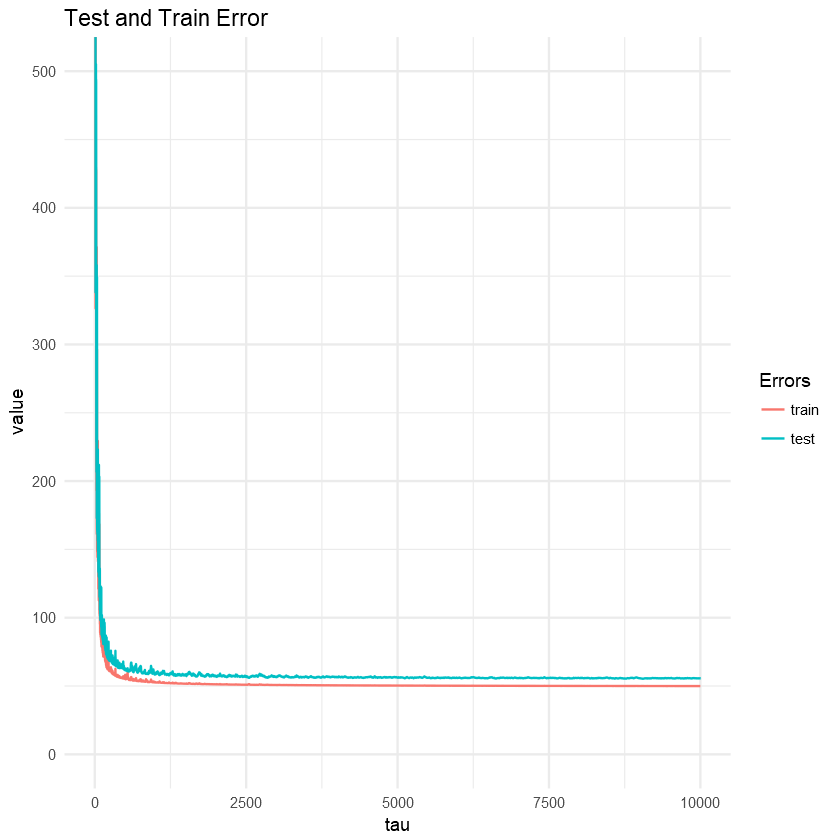

In [34]:

ggplot(data=result@error, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()+coord_cartesian(xlim = c(0, result@tauend), ylim = c(0, 500))
  

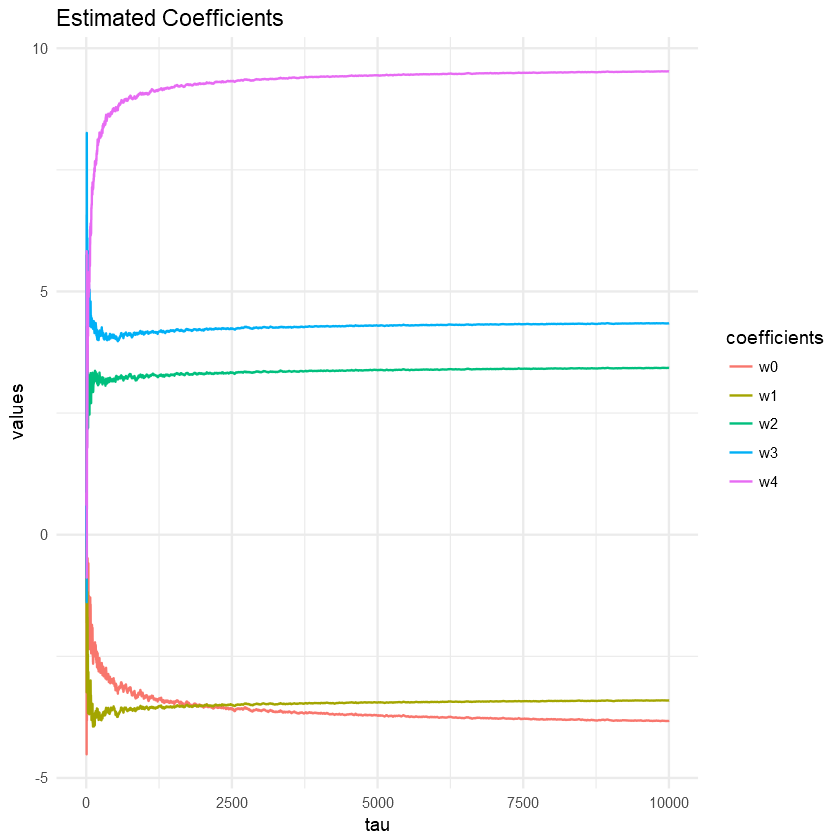

In [35]:
W.m <- as.data.frame(result@W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau <- 1:nrow(W.m)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()+coord_cartesian(xlim = c(0, result@tauend, ylim = c(-10, 10)))

In [36]:
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',result@W[result@tauend,])

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -3.828194 -3.405863 3.429263 4.34664 9.524876

*A very high learning rate for the first few iterations around 1(this makes the weights at this stage very dependent on the randomly selected first few samples) and the learning rate drops to 0.001 near the 10000th iteration

### Question 3

    3.Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training 
    data, 
    but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss 
    the convergence rates and final training error for SGD and batch GD.
    
*Batch GD is computationally intensive so should converge in less iterations but more computation time.*
*Each iteration is the equivalent of calculating the error 100 times*

In [37]:
#Code that sets up above algorithm as a function that is callable
bgd <- function(train.data = train.data,test.data = test.data,train.label= train.label,test.label = test.label, tau.max = 500, eta = 1, mineta= 0.001, epsilon = 0.1* mean(train.label)){


    # project data using a basis function (identical here)
    Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0
    T = train.label
    W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients for each Phi at each iteration
    set.seed(1234)
    W[1,] <- runif(ncol(Phi)) # initial weights. N.B. runif generates a random value from a uniform distribution between 0 and 1
                              # Random values are considered good choices but different starting values can result in 
                              # different local minima values. 

    error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

    tau <- 1 # iteration counter
    terminate <- FALSE #Flag to tell the Loop to stop running


            
    # check stopping condition:
    while(!terminate){
        terminate <- tau >= (tau.max-1) | error_func(Phi, W[tau,],T)<=epsilon

        #Set learning rate to be to default value
        eta_dash = eta
        error_curr = error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error_new = error_curr
        
        while(eta_dash >= mineta){

    
            for (j in 1:ncol(W)){
                # update the coefficient based on the learning rate and the error. 
                 W[(tau+1),j] <- W[tau,j] - eta_dash * grad_error_func(Phi,W[tau,],train.label)[j]
                }
            error_new = error_func(as.matrix(cbind(1, train.data)), W[tau+1,],train.label)
            
            if((eta_dash<mineta)|(error_new<error_curr)){
                break
            }else{
                eta_dash = eta_dash/2
            }
            

           
        }
        
        # record the train and test error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
            
        #Increase iteration count
        tau = tau + 1

    }

        
    #Adjust the formatting of error table    
    error.m <- melt(error[1:tau,], id='tau')

    # the  final result is:
    w <- W[tau,]
    cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

    return(new("BGDResult",
          W=W,
          tauend=tau,
          error= error.m))
    }


setClass(Class="BGDResult",
         representation(
            W="matrix",
            tauend="numeric",
            error = "data.frame"
        ))


In [38]:
result<- bgd(train.data,test.data,train.label,test.label,tau.max=50,eta=1,mineta=0.001,epsilon = 30)

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -3.414732 -3.493114 3.192248 4.158996 9.29532

Warning message:
"Removed 2 rows containing missing values (geom_path)."

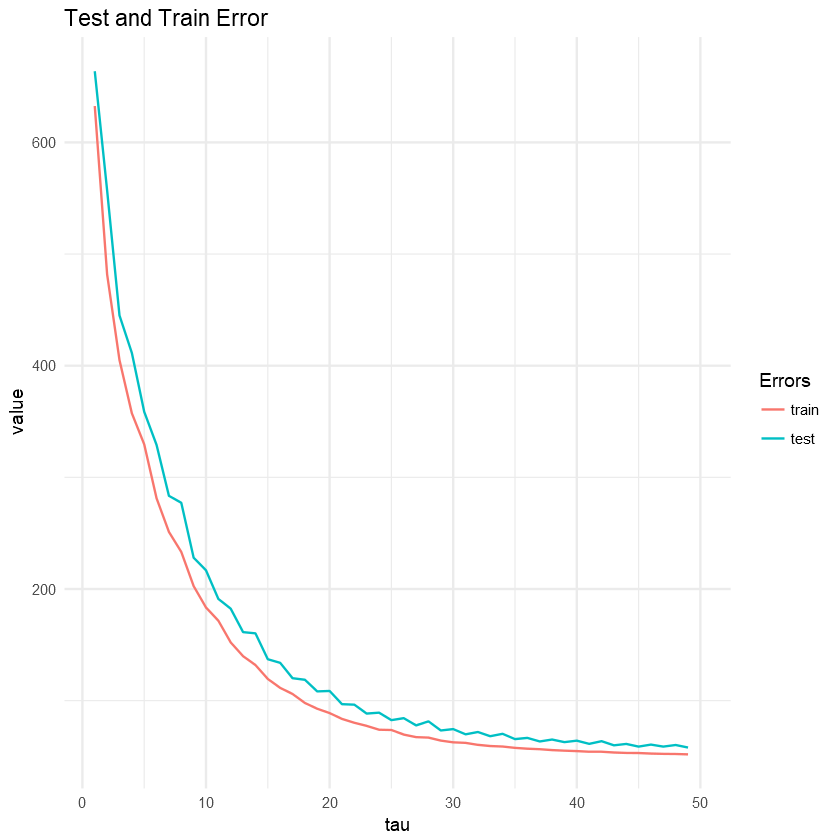

In [39]:
ggplot(data=result@error, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()

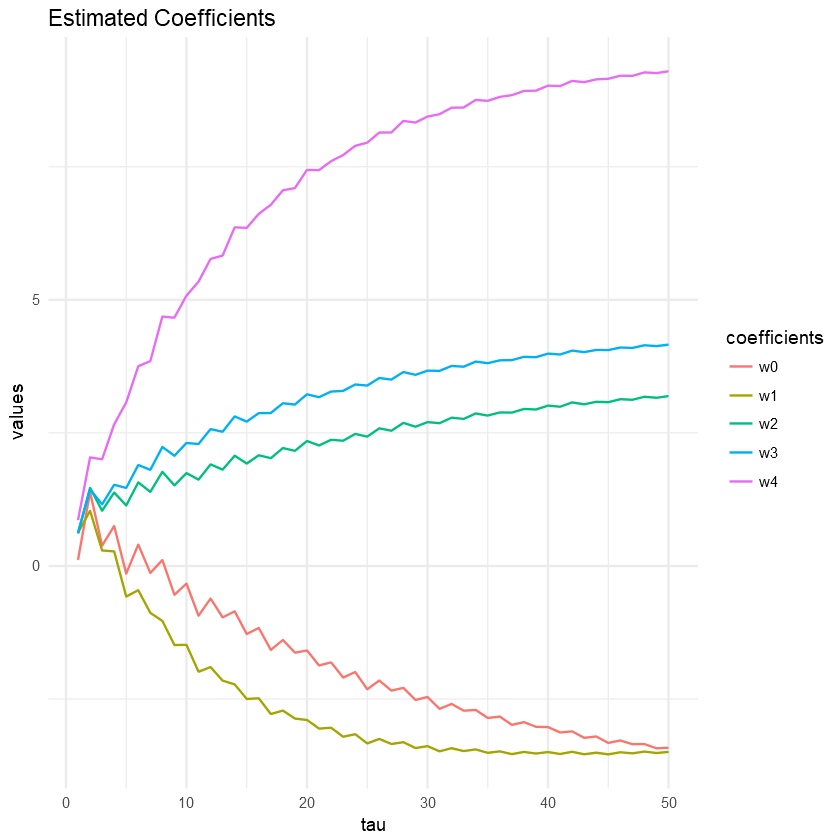

In [40]:
W.m <- as.data.frame(result@W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W.m)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()